# GitHub-Link
https://github.com/Tschoppsilas/GBSV_2025.git

# Tag 11

# Die beiden Filter
Meine Wahl der Filter für diese Aufgabe fiel auf CLAHE (Contrast Limited Adaptive Histogram Equalization) und auf den High-Pass-Filter im Frequenzbereich. Beide Methoden greifen tief in die Bildstruktur ein, ohne dabei Position, Form oder Ausrichtung der Objekte zu verändern. Dennoch bringen sie jeweils spezifische Stärken, aber auch Einschränkungen mit sich.
## CLAHE
CLAHE ist ein lokal adaptives Verfahren zur Kontrastverbesserung, das besonders bei kontrastarmen Bildern – etwa bei Nebel, diffusem Licht oder schattigen Berglandschaften – seine Stärken ausspielt. Die Methode teilt das Bild in kleine Blöcke auf und gleicht den Helligkeitskontrast innerhalb jeder Region separat aus. Das Ergebnis ist häufig ein sichtbar lebendigeres Bild mit hervorgehobenen Details, etwa in Felsen, Schneeflächen oder Wolkenstrukturen. Gerade in der Schweiz, wo viele Bilder aufgrund von Witterung oder Höhenlagen zu kontrastarm aufgenommen werden, kann CLAHE dazu beitragen, relevante Informationen besser sichtbar zu machen.

Kritisch zu betrachten ist allerdings, dass CLAHE – besonders bei ungünstiger Parametrisierung – zu unnatürlicher Bildwirkung führen kann. Bei zu hohem Clip-Limit oder zu kleiner Kachelgrösse entstehen sichtbare Artefakte oder übertriebene Kontraste, die das Bild eher verfälschen als verbessern. Auch kann die Methode bei stark verrauschten Bildern das Rauschen mitverstärken. Eine sorgfältige Feinabstimmung ist daher notwendig, um visuell überzeugende Ergebnisse zu erzielen.

## High-Pass-Filter
Der High-Pass-Filter in der Frequenzdomäne verfolgt einen gänzlich anderen Ansatz. Hier wird das Bild per Fourier-Transformation in seine Frequenzanteile zerlegt, wobei der Fokus auf der gezielten Verstärkung hochfrequenter Anteile – also feiner Details und Kanten – liegt. Niedrige Frequenzen, die für gleichmässige Flächen wie Himmel oder Wasser typisch sind, werden unterdrückt. Die resultierenden Bilder erscheinen dadurch schärfer, konturierter und mit einem betonten texturalen Charakter. Für Anwendungen wie die Analyse von Gebäudestrukturen in Städten wie Zürich oder der Erkennung von Gletscherspalten in Luftaufnahmen kann dies durchaus von Vorteil sein.

Allerdings bringt diese Methode ebenfalls Einschränkungen mit sich. Die Transformation in den Frequenzraum ist rechnerisch aufwändig und oft nicht intuitiv zu steuern. Kleine Fehler in der Wahl der Maskenparameter können dazu führen, dass wichtige Bildinhalte abgeschnitten oder ungewollt hervorgehoben werden. Zudem ist die entstehende Bildwirkung oft technisch und künstlich, was nicht für alle Anwendungen geeignet ist – insbesondere dann, wenn natürliche Bildästhetik erhalten bleiben soll.

## Fazit
Zusammenfassend lässt sich sagen, dass beide Verfahren wertvolle Werkzeuge zur nicht-geometrischen Bildaugmentation darstellen, aber jeweils mit Bedacht eingesetzt werden sollten. CLAHE eignet sich besonders zur Kontrastverbesserung in typischen schweizerischen Naturmotiven, während der High-Pass-Filter strukturierte oder urbane Szenen besser unterstützt. Ihre kombinierte Anwendung bietet interessante Perspektiven – erfordert aber eine kritische Auseinandersetzung mit ihren jeweiligen Nebeneffekten.



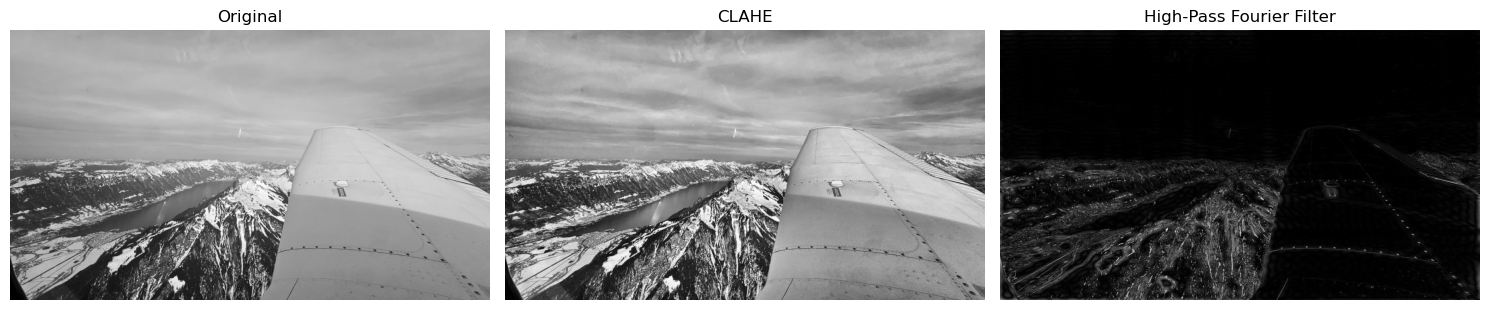

In [19]:
#Benötigte Bibliotheken
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift

#Hilfsfunktion zur Anzeige des Bildes
def show_images(images, titles, cmap='gray'):
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#dummy Bild aus dem letzten Kapitel
dummy_img = cv2.imread(cv2.samples.findFile("Data/Brienzersee.jpg"), cv2.IMREAD_GRAYSCALE)



#Augmentation: CLAHE
def clahe(img, clip_limit=2.0, tileGridSize=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tileGridSize)
    return clahe.apply(img)

img_clahe = clahe(dummy_img)

#ugmentation: High-Pass Filter in Fourier-Domäne
def apply_high_pass_filter(image: np.ndarray, radius: int = 30) -> np.ndarray:
    # Schritt 1: Fourier-Transformation und Zentrierung
    f = fft2(image)
    fshift = fftshift(f)

    # Schritt 2: Erstellen der High-Pass-Maske
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.ones((rows, cols), np.uint8)
    mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 0

    # Schritt 3: Anwenden der Maske
    fshift_filtered = fshift * mask

    # Schritt 4: Rücktransformation ins räumliche Bild
    img_filtered = np.abs(ifft2(ifftshift(fshift_filtered)))

    # Normalisierung und Konvertierung in 8-bit
    img_filtered = np.clip(img_filtered, 0, 255).astype(np.uint8)

    return img_filtered

img_filtered = apply_high_pass_filter(dummy_img, radius=30)

#Anzeige der Ergebnisse
show_images([dummy_img, img_clahe, img_filtered],
            ['Original', 'CLAHE', 'High-Pass Fourier Filter'])

# Tag 12
## Problem
In vielen fotografischen oder bildbasierten Anwendungen mit Bezug zur Schweiz – etwa in den Bereichen Landschaftsanalyse, Tourismusdarstellung oder städtische Infrastrukturplanung – sind Bilder von Natur- oder Stadtszenen häufig durch schwierige Lichtverhältnisse, Nebel oder gleichmässige Flächen in ihrer Informationsdichte eingeschränkt. Besonders in alpinen Regionen kann es durch diffuse Beleuchtung oder Schneedecken zu Kontrastverlusten kommen, während in urbanen Szenen wichtige strukturelle Details, wie Gebäudekanten oder Verkehrselemente, visuell untergehen.

## Ziel / Use Case
Ziel dieser Arbeit ist es daher, geeignete Augmentationsverfahren zu definieren und einzusetzen, die gezielt Kontraste verstärken und feine Details hervorheben, ohne dabei geometrische Eigenschaften des Bildes zu verändern. Dies ist insbesondere dann relevant, wenn die Bilder als Eingabedaten für automatisierte Analysesysteme dienen, z.B. zur Klassifikation oder Objekterkennung, bei denen visuelle Klarheit entscheidend ist.

## Wieso diese Methoden?
Die Wahl fiel auf zwei Methoden: CLAHE (Contrast Limited Adaptive Histogram Equalization) sowie einen High-Pass-Filter in der Frequenzdomäne. CLAHE verbessert lokal den Kontrast und ist besonders hilfreich, wenn wichtige Strukturen durch Nebel, Schatten oder gleichmässige Flächen verdeckt sind – ein häufiges Problem bei Landschaftsaufnahmen in der Schweiz. Der High-Pass-Filter wiederum betont hohe Frequenzen, also feine Details und Kanten, und ist daher besonders geeignet für urbane Bilder oder technische Strukturen. Beide Methoden verbessern die visuelle Aussagekraft von Bildern und tragen zur besseren Erkennung relevanter Inhalte bei, ohne geometrische Artefakte zu erzeugen. Damit stellen sie sinnvolle und gezielte Augmentierungen im Rahmen des gewählten Anwendungsfalls dar.

# Tag 13

# Parameter optimieren

## clip_limit
- Funktion: Begrenzt, wie stark der Kontrast in kleinen Bereichen erhöht wird.
- Wirkung:
    - Niedrig (z.B. 0.5–1.5): Sanfte Kontrastverbesserung, Details bleiben dezent.
    - Hoch (z.B. 4–10): Sehr starker Kontrast, helle/dunkle Bereiche können überbetont werden.
- Kritik: Ein zu hoher Wert kann unnatürliche Bildartefakte oder „Rauscheffekte“ erzeugen.

## tileGridSize
- Funktion: Bestimmt, in wie viele kleine Kacheln (tiles) das Bild aufgeteilt wird.
- Wirkung:
    - Kleine Werte (z.B. 4x4): Lokale Kontraste werden sehr fein angepasst – gut für Details.
    - Grosse Werte (z.B. 16x16, 32x32): Kontrasterhöhung ist globaler und gleichmässiger.
- Kritik: Ein zu hoher Wert kann unnatürliche Bildartefakte oder „Rauscheffekte“ erzeugen.

## radius
- Funktion: Gibt an, wie viel vom zentralen Frequenzbereich (also dem Bildinhalt mit wenig Detail) unterdrückt wird.
- Wirkung:
    - Klein (z.B. 5–20): Nur feinste Strukturen werden hervorgehoben.
    - Gross (z.B. 50–100): Auch grössere Details werden unterdrückt – das Bild wirkt wie eine Kantenkarte.
- Kritik: Ein zu grosser Radius kann das Bild zu stark abstrahieren; feine Strukturen werden dann zu stark betont, was in der Praxis zu verrauschten oder wenig interpretierbaren Bildern führen kann.

In [20]:
# Zusätzliche Bibliothek für Interaktivität (falls nicht installiert: pip install ipywidgets)
import ipywidgets as widgets
from IPython.display import display

#Interaktive Parameteroptimierung für ein beliebiges Bild
def interactive_augmentation(img):
    def update(clip_limit, tile_size, hp_radius):
        img_clahe = clahe(img, clip_limit=clip_limit, tileGridSize=(tile_size, tile_size))
        img_hp = apply_high_pass_filter(img, radius=hp_radius)
        show_images(
            [img, img_clahe, img_hp],
            [f'Original',
             f'CLAHE (Clip={clip_limit}, Tile={tile_size}x{tile_size})',
             f'High-Pass (Radius={hp_radius})']
        )
    
    # Widgets
    clip_slider = widgets.FloatSlider(value=2.0, min=0.5, max=10.0, step=0.5, description='CLAHE Clip:')
    tile_slider = widgets.IntSlider(value=8, min=2, max=32, step=2, description='Tile Size:')
    hp_slider = widgets.IntSlider(value=30, min=5, max=100, step=5, description='HP Radius:')
    
    ui = widgets.VBox([clip_slider, tile_slider, hp_slider])
    out = widgets.interactive_output(update, {
        'clip_limit': clip_slider,
        'tile_size': tile_slider,
        'hp_radius': hp_slider
    })
    
    display(ui, out)

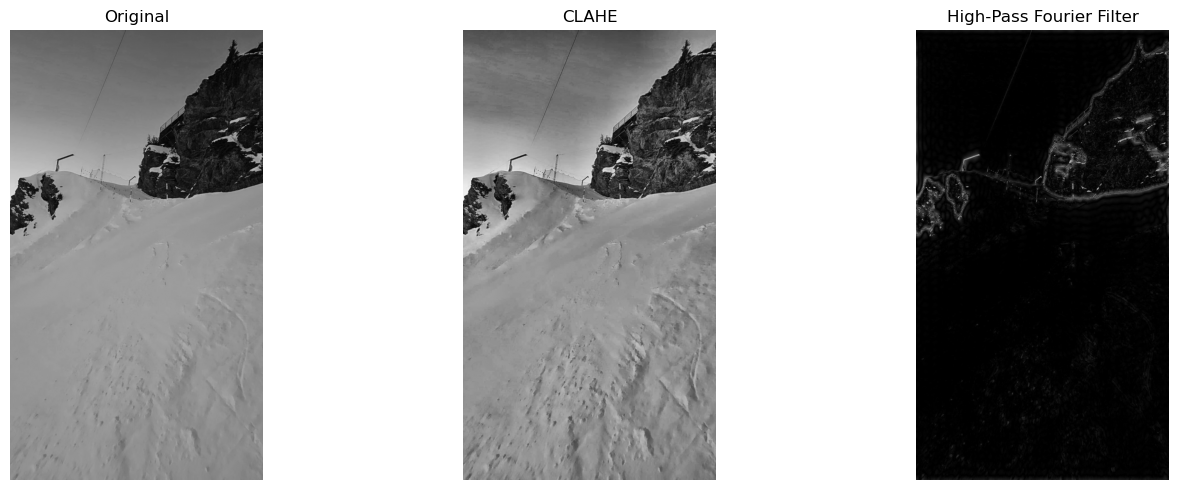

In [21]:
hundschopf_img = cv2.imread(cv2.samples.findFile("Data/Hundschopf.jpg"), cv2.IMREAD_GRAYSCALE)

img_clahe = clahe(hundschopf_img)

img_filtered = apply_high_pass_filter(hundschopf_img, radius=30)

#Anzeige der Ergebnisse
show_images([hundschopf_img, img_clahe, img_filtered],
            ['Original', 'CLAHE', 'High-Pass Fourier Filter'])

Optimize Hundschopf

In [28]:
interactive_augmentation(hundschopf_img)

Output()

Finale Parameter

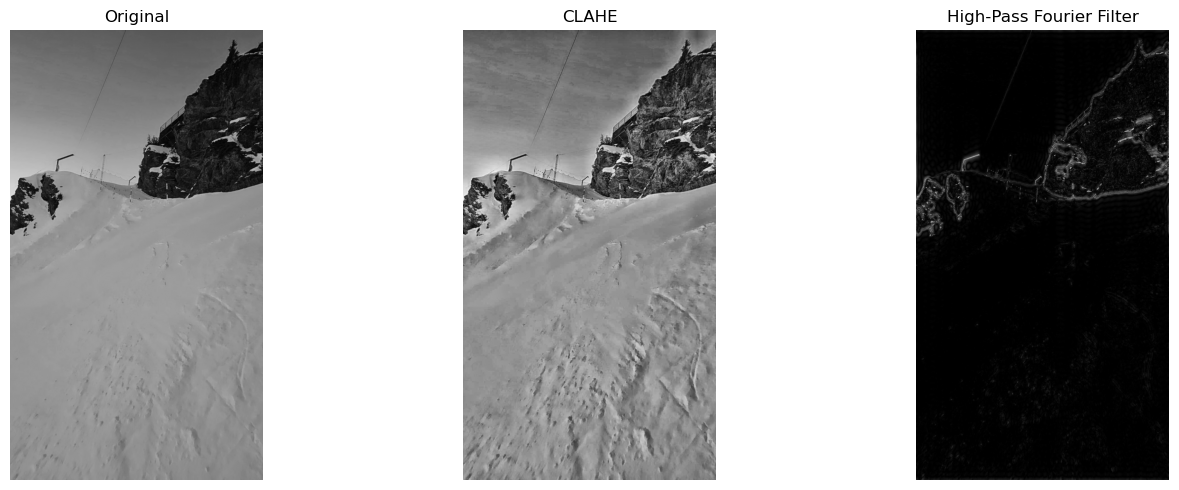

In [33]:
hundschopf_img = cv2.imread(cv2.samples.findFile("Data/Hundschopf.jpg"), cv2.IMREAD_GRAYSCALE)

img_clahe = clahe(hundschopf_img, clip_limit=3.0, tileGridSize=(20, 20))

img_filtered = apply_high_pass_filter(hundschopf_img, radius=40)

#Anzeige der Ergebnisse
show_images([hundschopf_img, img_clahe, img_filtered],
            ['Original', 'CLAHE', 'High-Pass Fourier Filter'])

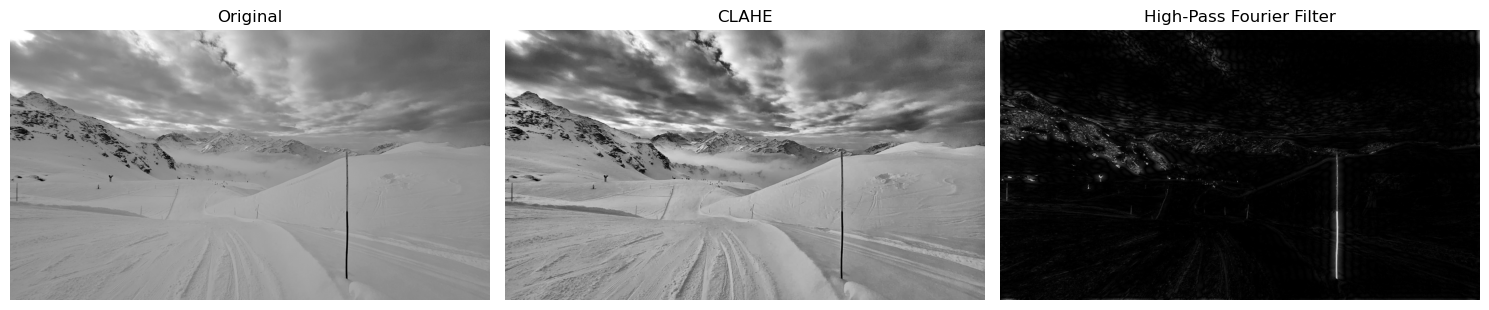

In [23]:
quatre_vallee_img = cv2.imread(cv2.samples.findFile("Data/quatre_vallee.jpg"), cv2.IMREAD_GRAYSCALE)

img_clahe = clahe(quatre_vallee_img)

img_filtered = apply_high_pass_filter(quatre_vallee_img, radius=30)

#Anzeige der Ergebnisse
show_images([quatre_vallee_img, img_clahe, img_filtered],
            ['Original', 'CLAHE', 'High-Pass Fourier Filter'])

Optimiere Quatre Vallee

In [25]:
interactive_augmentation(quatre_vallee_img)

Output()

Finale Parameter

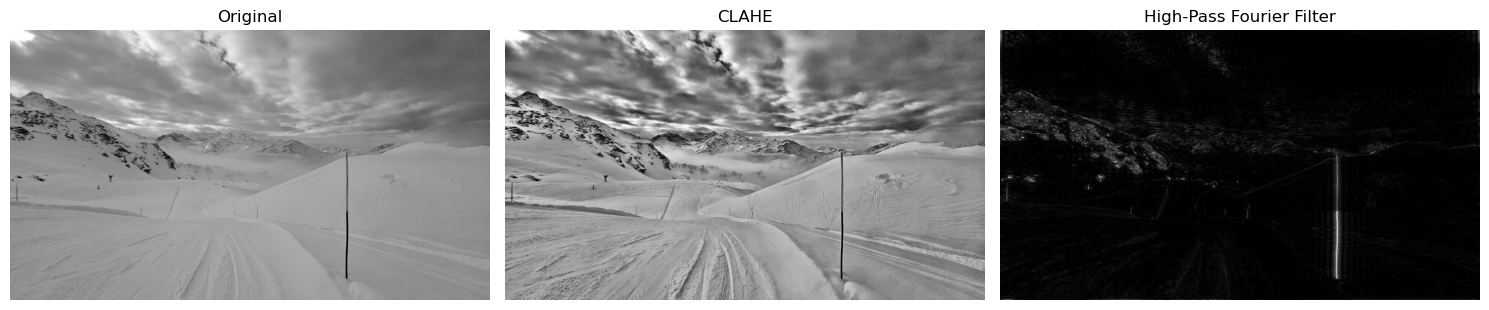

In [34]:
quatre_vallee_img = cv2.imread(cv2.samples.findFile("Data/quatre_vallee.jpg"), cv2.IMREAD_GRAYSCALE)

img_clahe = clahe(quatre_vallee_img, clip_limit=3.0, tileGridSize=(20, 20))

img_filtered = apply_high_pass_filter(quatre_vallee_img, radius=40)

#Anzeige der Ergebnisse
show_images([quatre_vallee_img, img_clahe, img_filtered],
            ['Original', 'CLAHE', 'High-Pass Fourier Filter'])

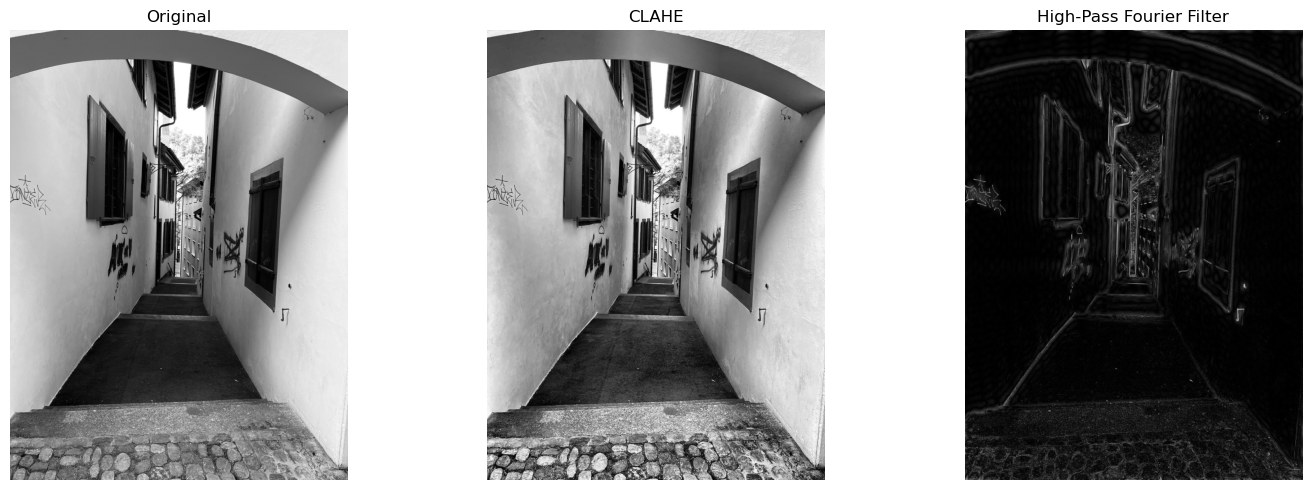

In [24]:
basler_gaesslein_img = cv2.imread(cv2.samples.findFile("Data/Basler_gasslein.jpg"), cv2.IMREAD_GRAYSCALE)

img_clahe = clahe(basler_gaesslein_img)

img_filtered = apply_high_pass_filter(basler_gaesslein_img, radius=30)

#Anzeige der Ergebnisse
show_images([basler_gaesslein_img, img_clahe, img_filtered],
            ['Original', 'CLAHE', 'High-Pass Fourier Filter'])

Basler Gässlein Optimieren

In [31]:
interactive_augmentation(basler_gaesslein_img)

Output()